In [1]:
# !pip install tensorflow==2.14.0 tensorflow-probability==0.22.0

In [13]:
import numpy as np
import numpy as np
import tensorflow as tf
import random
import tf_agents.environments as tf_env
import tf_agents.specs as tf_specs
from tf_agents.trajectories import time_step as ts
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

User profile with base change probability 0.28 and lambda fatigue 0.09
True values: -0.44677559890129837
Value estimates: [-0.44444444 -1.         -1.         -1.          0.99159664]
Action counts: [  9.   5.   5.   5. 476.]
User profile with base change probability 0.24 and lambda fatigue 0.02
True values: -0.519267989958337
Value estimates: [-0.44444444 -0.71428571 -1.         -0.5         0.93630573]
Action counts: [  9.   7.   5.   8. 471.]
User profile with base change probability 0.16 and lambda fatigue 0.08
True values: -0.6856066543577313
Value estimates: [-0.83333333 -1.         -1.         -1.          0.99164927]
Action counts: [  6.   5.   5.   5. 479.]
User profile with base change probability 0.35 and lambda fatigue 0.01
True values: -0.30542554934699107
Value estimates: [-0.25       -0.55555556 -1.         -1.          0.90618337]
Action counts: [ 12.   9.   5.   5. 469.]
User profile with base change probability 0.13 and lambda fatigue 0.07
True values: -0.732714555108

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

User profile with base change probability 0.19 and lambda fatigue 0.10
True values: -0.6211233291844378
Value estimates: [-0.83333333 -1.         -1.         -1.          0.99164927]
Action counts: [  6.   5.   5.   5. 479.]
User profile with base change probability 0.10 and lambda fatigue 0.10
True values: -0.7902764202481469
Value estimates: [-0.83333333 -1.         -1.         -1.          0.99164927]
Action counts: [  6.   5.   5.   5. 479.]
User profile with base change probability 0.12 and lambda fatigue 0.09
True values: -0.7654720704395391
Value estimates: [-0.83333333 -1.         -1.         -1.          0.99164927]
Action counts: [  6.   5.   5.   5. 479.]
User profile with base change probability 0.31 and lambda fatigue 0.10
True values: -0.37783911273096016
Value estimates: [-0.44444444 -1.         -1.         -1.          0.99159664]
Action counts: [  9.   5.   5.   5. 476.]
User profile with base change probability 0.13 and lambda fatigue 0.06
True values: -0.740962748211

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

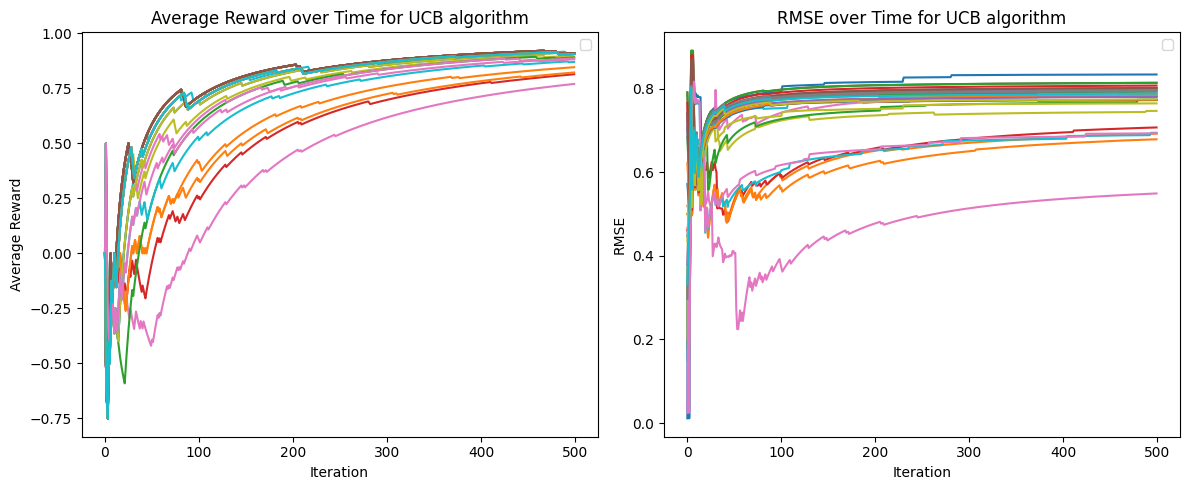

In [26]:
class FiveArmedBanditEnv(tf_env.py_environment.PyEnvironment):
    def __init__(self, user_model_vec, change_probability=0.3, lambda_fatigue=0.01, seed=42):
        self._num_actions = 5
        self._user_model_vec = user_model_vec
        self._change_probability = change_probability
        self._lambda_fatigue = lambda_fatigue
        self._step_count = 0
        self._total_reward = 0.0
        self._dummy_observation = np.array([0.0, 0.0, 0.0, 0.0, 0.0], dtype=np.float32)
        np.random.seed(seed)
        super(FiveArmedBanditEnv, self).__init__()

    def action_spec(self):
        return tf_specs.BoundedArraySpec(
            shape=(), dtype=np.int32, minimum=0, maximum=self._num_actions - 1, name='action')

    def observation_spec(self):
        return tf_specs.BoundedArraySpec(
            shape=(self._num_actions,), dtype=np.float32, minimum=0, name='observation')

    def _reset(self):
        self._step_count = 0
        self._total_reward = 0.0
        return ts.restart(observation=self._dummy_observation)
    
    def _step(self, action):
        fatigue = 1 - np.exp(-self._lambda_fatigue * self._step_count)
        adjusted_change_probability = self._change_probability * (1 - fatigue)

        if np.random.uniform(0, 1) < adjusted_change_probability:
            self.current_state = 'changed_posture'
        else:
            self.current_state = 'same_posture'

        # Define rewards based on the state and action
        if self.current_state == 'changed_posture':
            reward = 1 if action != 4 else -1  # Positive reward for any action except 'stay'
        else:
            reward = -1 if action != 4 else 1  # Negative reward for any action except 'stay'

        self._step_count += 1
        self._total_reward += reward

        return ts.transition(observation=self._dummy_observation, reward=reward)
    
    def get_total_reward(self):
        return self._total_reward

    def get_step_count(self):
        return self._step_count

def generate_user_profiles(num_profiles, base_change_probability_range, lambda_fatigue_range):
    user_profiles = []
    for _ in range(num_profiles):
        base_change_probability = np.random.uniform(*base_change_probability_range)
        lambda_fatigue = np.random.uniform(*lambda_fatigue_range)
        user_profiles.append((base_change_probability, lambda_fatigue))
    return user_profiles

#UCB1 Agent
class UCB1Agent:
    def __init__(self, num_actions, explore_rate=2.0):
        self.num_actions = num_actions
        self.explore_rate = explore_rate
        self.action_counts = np.zeros(num_actions)
        self.action_values = np.zeros(num_actions)
        self.total_steps = 0

    def select_action(self):
        ucb_values = self.action_values + self.explore_rate * np.sqrt(np.log(self.total_steps + 1) / (self.action_counts + 1))
        return np.argmax(ucb_values)

    def update_estimates(self, action, reward):
        self.total_steps += 1
        self.action_counts[action] += 1
        alpha = 1 / self.action_counts[action]
        self.action_values[action] += alpha * (reward - self.action_values[action])

    def get_current_average_reward(self):
        return np.sum(self.action_values * self.action_counts) / np.sum(self.action_counts)


def user_simulation_ucb(user_profiles, num_iterations=500, explore_rate=2.0):
    all_average_rewards = []
    all_rmse = []

    for base_change_probability, lambda_fatigue in user_profiles:
        # Create the environment
        env = FiveArmedBanditEnv(user_model_vec=None, change_probability=base_change_probability, lambda_fatigue=lambda_fatigue)

        # Create the UCB1 agent
        agent = UCB1Agent(num_actions=env.action_spec().maximum + 1, explore_rate=explore_rate)
    
        average_rewards = []
        rmse = []

        # Training loop
        for _ in range(num_iterations):
            # Main stepping
            action = agent.select_action()
            time_step = env.step(action)
            agent.update_estimates(action, time_step.reward)

            # Logs for plotting
            average_rewards.append(agent.get_current_average_reward())
            true_action_value = 2 * base_change_probability - 1
            rmse.append(np.sqrt(np.mean((np.subtract(agent.action_values, true_action_value))**2)))

        all_average_rewards.append(average_rewards)
        all_rmse.append(rmse)

        print(f"User profile with base change probability {base_change_probability:.2f} and lambda fatigue {lambda_fatigue:.2f}")
        print("True values: {}".format(true_action_value))
        print("Value estimates: {}".format(agent.action_values))
        print("Action counts: {}".format(agent.action_counts))

    return all_average_rewards, all_rmse

if __name__ == "__main__":
    num_profiles = 30 # We want enough profiles to see the variance in the results but not too many to stay feasible in the real experiment
    base_change_probability_range = (0.1, 0.5) # At minimum, the user changes posture 10% of the time and at maximum 50% of the time
    lambda_fatigue_range = (0.005, 0.1) # In the paper the values chosen were 0.01, 0.03 and 0.05
    
    user_profiles = generate_user_profiles(num_profiles, base_change_probability_range, lambda_fatigue_range)
    average_rewards, rmse = user_simulation_ucb(user_profiles)

    plt.figure(figsize=(12, 5))

    for i, (avg_rewards, rms) in enumerate(zip(average_rewards, rmse)):
        plt.subplot(1, 2, 1)
        plt.plot(avg_rewards)
        plt.xlabel('Iteration')
        plt.ylabel('Average Reward')
        plt.title('Average Reward over Time for UCB algorithm')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(rms)
        plt.xlabel('Iteration')
        plt.ylabel('RMSE')
        plt.title('RMSE over Time for UCB algorithm')
        plt.legend()

    plt.tight_layout()
    plt.show()


User profile with base change probability 0.27 and lambda fatigue 0.03
True values: -0.4647351477838899
Value estimates: [-0.36363636 -1.         -1.         -1.          0.97046414]
Action counts: [ 11.   5.   5.   5. 474.]
User profile with base change probability 0.41 and lambda fatigue 0.01
True values: -0.18005544157408782
Value estimates: [-0.36363636 -0.71428571 -0.4        -0.125       0.90350877]
Action counts: [ 11.   7.  10.  16. 456.]
User profile with base change probability 0.16 and lambda fatigue 0.07
True values: -0.676157511294446
Value estimates: [-0.83333333 -1.         -1.         -1.          0.99164927]
Action counts: [  6.   5.   5.   5. 479.]
User profile with base change probability 0.41 and lambda fatigue 0.02
True values: -0.17044043161732847
Value estimates: [-0.36363636 -0.71428571 -0.4        -0.125       0.90789474]
Action counts: [ 11.   7.  10.  16. 456.]
User profile with base change probability 0.25 and lambda fatigue 0.04
True values: -0.492217468578

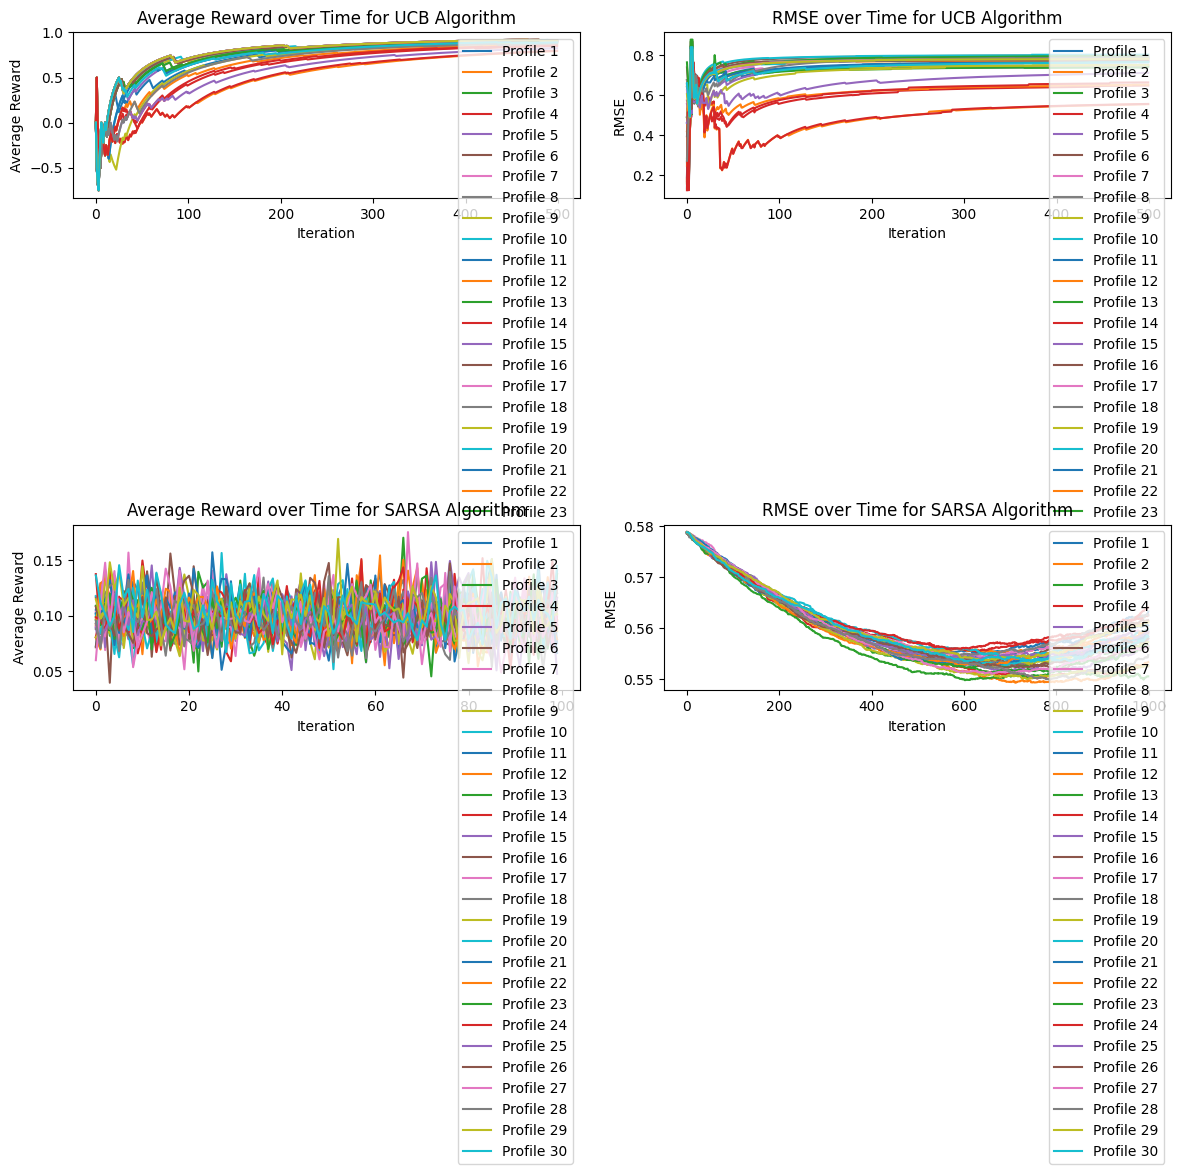

In [30]:
import numpy as np
import random
import matplotlib.pyplot as plt

# SARSA Agent Implementation
class SARSAAgent:
    def __init__(self, n_states, n_actions, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.n_states = n_states
        self.n_actions = n_actions
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate
        self.Q = np.zeros((n_states, n_actions))  # Initialize Q-values
        self.rmse_history = []

    def choose_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return np.random.choice(self.n_actions)  
        else:
            return np.argmax(self.Q[state])  

    def update(self, state, action, reward, next_state, next_action):
        predict = self.Q[state, action]
        target = reward + self.gamma * self.Q[next_state, next_action]
        self.Q[state, action] += self.alpha * (target - predict)

    def calculate_rmse(self, true_values):
        return np.sqrt(((self.Q - true_values) ** 2).mean())

    def train(self, environment, true_values, episodes=1000):
        for episode in range(episodes):
            state = environment.reset()
            action = self.choose_action(state)
            
            episode_rewards = 0  

            while True:
                next_state, reward, done, _ = environment.step(action)
                next_action = self.choose_action(next_state)
                
                self.update(state, action, reward, next_state, next_action)
                
                state = next_state
                action = next_action

                episode_rewards += reward  

                if done:
                    break

            rmse = self.calculate_rmse(true_values)
            self.rmse_history.append(rmse)
            
            print(f"Episode {episode + 1}/{episodes}, RMSE: {rmse:.4f}, Total Reward: {episode_rewards}")

    def plot_rmse(self):
        plt.plot(self.rmse_history)
        plt.xlabel('Episodes')
        plt.ylabel('RMSE')
        plt.title('RMSE over Episodes for SARSA')
        plt.show()

class Environment:
    def __init__(self, n_states, n_actions):
        self.n_states = n_states
        self.n_actions = n_actions
    
    def reset(self):
        return np.random.randint(0, self.n_states)
    
    def step(self, action):
        next_state = np.random.randint(0, self.n_states)
        reward = np.random.random()  
        done = np.random.choice([True, False])  
        return next_state, reward, done, {}

def generate_user_profiles(num_profiles, base_change_probability_range, lambda_fatigue_range):
    user_profiles = []
    for _ in range(num_profiles):
        base_change_probability = random.uniform(*base_change_probability_range)
        lambda_fatigue = random.uniform(*lambda_fatigue_range)
        user_profiles.append((base_change_probability, lambda_fatigue))
    return user_profiles

def user_simulation(user_profiles, agent_type='UCB', episodes=1000):
    average_rewards = []
    rmse = []
    n_states = 100  
    n_actions = 10  
    environment = Environment(n_states, n_actions)
    true_values = np.random.rand(n_states, n_actions)  
    
    for profile in user_profiles:
        if agent_type == 'UCB':
            ucb_agent = UCB1Agent(n_actions)
            average_rewards, rmse = user_simulation_ucb(user_profiles)
            # pass
        elif agent_type == 'SARSA':
            sarsa_agent = SARSAAgent(n_states, n_actions)
            sarsa_agent.train(environment, true_values, episodes)
            average_rewards.append(np.mean(sarsa_agent.Q, axis=1))  
            rmse.append(sarsa_agent.rmse_history)

    # for profile in user_profiles:
    #     if agent_type == 'SARSA':
    #         sarsa_agent = SARSAAgent(n_states, n_actions)
    #         sarsa_agent.train(environment, true_values, episodes)
    #         average_rewards.append(np.mean(sarsa_agent.Q, axis=1))  
    #         rmse.append(sarsa_agent.rmse_history)
    
    return average_rewards, rmse

if __name__ == "__main__":
    num_profiles = 30  # Number of user profiles
    base_change_probability_range = (0.1, 0.5)  # Range of base change probabilities
    lambda_fatigue_range = (0.005, 0.1)  # Range of lambda fatigue values

    # Generate user profiles
    user_profiles = generate_user_profiles(num_profiles, base_change_probability_range, lambda_fatigue_range)

    # Run simulations for UCB and SARSA
    average_rewards_ucb, rmse_ucb = user_simulation(user_profiles, agent_type='UCB')
    average_rewards_sarsa, rmse_sarsa = user_simulation(user_profiles, agent_type='SARSA')

    # Plotting
    plt.figure(figsize=(12, 10))

    # Plot Average Reward for UCB
    plt.subplot(2, 2, 1)
    for i, avg_rewards in enumerate(average_rewards_ucb):
        plt.plot(avg_rewards, label=f'Profile {i + 1}')
    plt.xlabel('Iteration')
    plt.ylabel('Average Reward')
    plt.title('Average Reward over Time for UCB Algorithm')
    plt.legend()

    # Plot RMSE for UCB
    plt.subplot(2, 2, 2)
    for i, rms in enumerate(rmse_ucb):
        plt.plot(rms, label=f'Profile {i + 1}')
    plt.xlabel('Iteration')
    plt.ylabel('RMSE')
    plt.title('RMSE over Time for UCB Algorithm')
    plt.legend()

    # Plot Average Reward for SARSA
    plt.subplot(2, 2, 3)
    for i, avg_rewards in enumerate(average_rewards_sarsa):
        plt.plot(avg_rewards, label=f'Profile {i + 1}')
    plt.xlabel('Iteration')
    plt.ylabel('Average Reward')
    plt.title('Average Reward over Time for SARSA Algorithm')
    plt.legend()

    # Plot RMSE for SARSA
    plt.subplot(2, 2, 4)
    for i, rms in enumerate(rmse_sarsa):
        plt.plot(rms, label=f'Profile {i + 1}')
    plt.xlabel('Iteration')
    plt.ylabel('RMSE')
    plt.title('RMSE over Time for SARSA Algorithm')
    plt.legend()

    plt.tight_layout()
    plt.show()


Episode 1/1000, RMSE: 0.5769, Total Reward: 0.6134113892107077
Episode 2/1000, RMSE: 0.5768, Total Reward: 0.9497575019139525
Episode 3/1000, RMSE: 0.5768, Total Reward: 0.18643826214425452
Episode 4/1000, RMSE: 0.5768, Total Reward: 0.05784267656339637
Episode 5/1000, RMSE: 0.5768, Total Reward: 0.7784937346279195
Episode 6/1000, RMSE: 0.5766, Total Reward: 1.7356713578670329
Episode 7/1000, RMSE: 0.5766, Total Reward: 0.8949214412278399
Episode 8/1000, RMSE: 0.5765, Total Reward: 0.8774608626303804
Episode 9/1000, RMSE: 0.5763, Total Reward: 2.3160249435637708
Episode 10/1000, RMSE: 0.5761, Total Reward: 1.4809659062113973
Episode 11/1000, RMSE: 0.5760, Total Reward: 0.6832587636595959
Episode 12/1000, RMSE: 0.5760, Total Reward: 0.06151702623923505
Episode 13/1000, RMSE: 0.5758, Total Reward: 1.5059489565575017
Episode 14/1000, RMSE: 0.5757, Total Reward: 1.64800775070117
Episode 15/1000, RMSE: 0.5757, Total Reward: 0.3340088787452379
Episode 16/1000, RMSE: 0.5757, Total Reward: 0.6

Episode 567/1000, RMSE: 0.5489, Total Reward: 1.0281279272085477
Episode 568/1000, RMSE: 0.5489, Total Reward: 0.19872792203306322
Episode 569/1000, RMSE: 0.5489, Total Reward: 1.5826798367664008
Episode 570/1000, RMSE: 0.5489, Total Reward: 0.8364984906180335
Episode 571/1000, RMSE: 0.5488, Total Reward: 1.5333617459482232
Episode 572/1000, RMSE: 0.5487, Total Reward: 0.8244715176045491
Episode 573/1000, RMSE: 0.5485, Total Reward: 1.2099578477410196
Episode 574/1000, RMSE: 0.5485, Total Reward: 0.7615876902801363
Episode 575/1000, RMSE: 0.5485, Total Reward: 0.6966951114367486
Episode 576/1000, RMSE: 0.5485, Total Reward: 0.728370854339646
Episode 577/1000, RMSE: 0.5485, Total Reward: 0.82042682025902
Episode 578/1000, RMSE: 0.5485, Total Reward: 2.4930723512906656
Episode 579/1000, RMSE: 0.5483, Total Reward: 0.49689551850004887
Episode 580/1000, RMSE: 0.5483, Total Reward: 0.1602256009765063
Episode 581/1000, RMSE: 0.5483, Total Reward: 1.064777383091846
Episode 582/1000, RMSE: 0.5

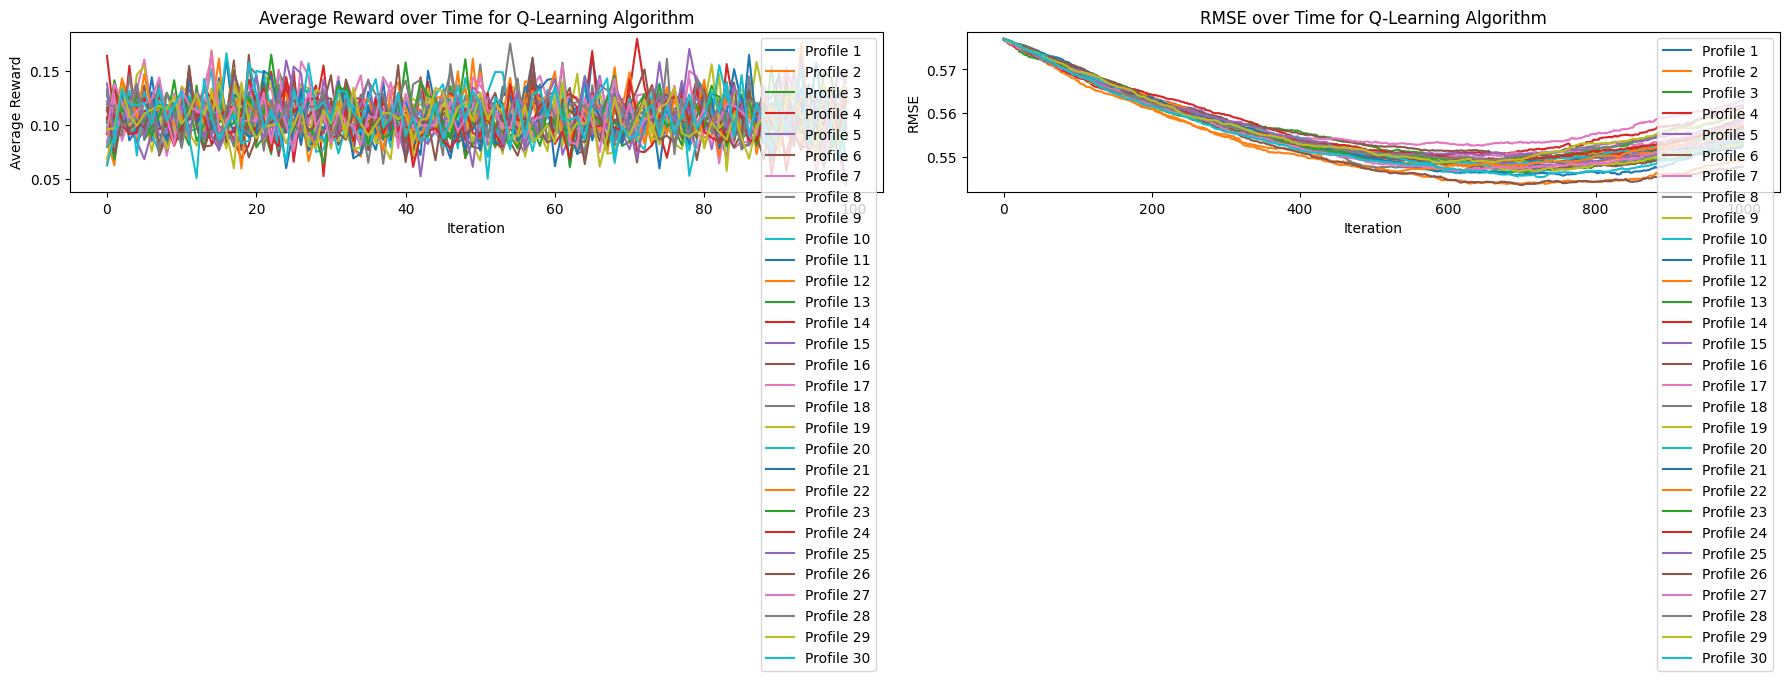

In [32]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Q-Learning Agent Implementation
class QLearningAgent:
    def __init__(self, n_states, n_actions, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.n_states = n_states
        self.n_actions = n_actions
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate
        self.Q = np.zeros((n_states, n_actions))  # Initialize Q-values
        self.rmse_history = []

    def choose_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return np.random.choice(self.n_actions)  # Explore
        else:
            return np.argmax(self.Q[state])  # Exploit

    def update(self, state, action, reward, next_state):
        predict = self.Q[state, action]
        target = reward + self.gamma * np.max(self.Q[next_state])
        self.Q[state, action] += self.alpha * (target - predict)

    def calculate_rmse(self, true_values):
        return np.sqrt(((self.Q - true_values) ** 2).mean())

    def train(self, environment, true_values, episodes=1000):
        for episode in range(episodes):
            state = environment.reset()
            
            episode_rewards = 0  # To keep track of rewards for this episode

            while True:
                action = self.choose_action(state)
                next_state, reward, done, _ = environment.step(action)
                
                self.update(state, action, reward, next_state)
                
                state = next_state

                episode_rewards += reward  # Accumulate rewards

                if done:
                    break

            # Calculate and store RMSE for this episode
            rmse = self.calculate_rmse(true_values)
            self.rmse_history.append(rmse)
            
            print(f"Episode {episode + 1}/{episodes}, RMSE: {rmse:.4f}, Total Reward: {episode_rewards}")

    def plot_rmse(self):
        plt.plot(self.rmse_history)
        plt.xlabel('Episodes')
        plt.ylabel('RMSE')
        plt.title('RMSE over Episodes for Q-Learning')
        plt.show()

# Placeholder for the environment class with a compatible interface
class Environment:
    def __init__(self, n_states, n_actions):
        self.n_states = n_states
        self.n_actions = n_actions
    
    def reset(self):
        # Reset the environment to the initial state and return the initial state
        return np.random.randint(0, self.n_states)
    
    def step(self, action):
        # Take an action, return next_state, reward, done, and info
        next_state = np.random.randint(0, self.n_states)
        reward = np.random.random()  # Example reward
        done = np.random.choice([True, False])  # Example termination
        return next_state, reward, done, {}

# Function to generate user profiles
def generate_user_profiles(num_profiles, base_change_probability_range, lambda_fatigue_range):
    user_profiles = []
    for _ in range(num_profiles):
        base_change_probability = random.uniform(*base_change_probability_range)
        lambda_fatigue = random.uniform(*lambda_fatigue_range)
        user_profiles.append((base_change_probability, lambda_fatigue))
    return user_profiles

# Function to simulate user interaction and return average rewards and RMSE
def user_simulation(user_profiles, agent_type='UCB', episodes=1000):
    average_rewards = []
    rmse = []
    n_states = 100  # Example number of states
    n_actions = 10  # Example number of actions
    environment = Environment(n_states, n_actions)
    true_values = np.random.rand(n_states, n_actions)  # Example true values for RMSE calculation
    
    for profile in user_profiles:
        # if agent_type == 'UCB':
        #     ucb_agent = UCB1Agent(n_actions)
        #     average_rewards, rmse = user_simulation_ucb(user_profiles)
        # elif agent_type == 'SARSA':
        #     sarsa_agent = SARSAAgent(n_states, n_actions)
        #     sarsa_agent.train(environment, true_values, episodes)
        #     average_rewards.append(np.mean(sarsa_agent.Q, axis=1))  
        #     rmse.append(sarsa_agent.rmse_history)
        if agent_type == 'Q-Learning':
            q_learning_agent = QLearningAgent(n_states, n_actions)
            q_learning_agent.train(environment, true_values, episodes)
            average_rewards.append(np.mean(q_learning_agent.Q, axis=1))  
            rmse.append(q_learning_agent.rmse_history)
    
    return average_rewards, rmse

if __name__ == "__main__":
    num_profiles = 30  # Number of user profiles
    base_change_probability_range = (0.1, 0.5)  # Range of base change probabilities
    lambda_fatigue_range = (0.005, 0.1)  # Range of lambda fatigue values

    # Generate user profiles
    user_profiles = generate_user_profiles(num_profiles, base_change_probability_range, lambda_fatigue_range)

    # Run simulations for UCB, SARSA, and Q-Learning
    # average_rewards_ucb, rmse_ucb = user_simulation(user_profiles, agent_type='UCB')
    # average_rewards_sarsa, rmse_sarsa = user_simulation(user_profiles, agent_type='SARSA')
    average_rewards_q_learning, rmse_q_learning = user_simulation(user_profiles, agent_type='Q-Learning')

    # Plotting
    plt.figure(figsize=(18, 10))

    # # Plot Average Reward for UCB
    # plt.subplot(3, 2, 1)
    # for i, avg_rewards in enumerate(average_rewards_ucb):
    #     plt.plot(avg_rewards, label=f'Profile {i + 1}')
    # plt.xlabel('Iteration')
    # plt.ylabel('Average Reward')
    # plt.title('Average Reward over Time for UCB Algorithm')
    # plt.legend()

    # # Plot RMSE for UCB
    # plt.subplot(3, 2, 2)
    # for i, rms in enumerate(rmse_ucb):
    #     plt.plot(rms, label=f'Profile {i + 1}')
    # plt.xlabel('Iteration')
    # plt.ylabel('RMSE')
    # plt.title('RMSE over Time for UCB Algorithm')
    # plt.legend()

    # # Plot Average Reward for SARSA
    # plt.subplot(3, 2, 3)
    # for i, avg_rewards in enumerate(average_rewards_sarsa):
    #     plt.plot(avg_rewards, label=f'Profile {i + 1}')
    # plt.xlabel('Iteration')
    # plt.ylabel('Average Reward')
    # plt.title('Average Reward over Time for SARSA Algorithm')
    # plt.legend()

    # # Plot RMSE for SARSA
    # plt.subplot(3, 2, 4)
    # for i, rms in enumerate(rmse_sarsa):
    #     plt.plot(rms, label=f'Profile {i + 1}')
    # plt.xlabel('Iteration')
    # plt.ylabel('RMSE')
    # plt.title('RMSE over Time for SARSA Algorithm')
    # plt.legend()

    # Plot Average Reward for Q-Learning
    plt.subplot(3, 2, 5)
    for i, avg_rewards in enumerate(average_rewards_q_learning):
        plt.plot(avg_rewards, label=f'Profile {i + 1}')
    plt.xlabel('Iteration')
    plt.ylabel('Average Reward')
    plt.title('Average Reward over Time for Q-Learning Algorithm')
    plt.legend()

    # Plot RMSE for Q-Learning
    plt.subplot(3, 2, 6)
    for i, rms in enumerate(rmse_q_learning):
        plt.plot(rms, label=f'Profile {i + 1}')
    plt.xlabel('Iteration')
    plt.ylabel('RMSE')
    plt.title('RMSE over Time for Q-Learning Algorithm')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [12]:
# class QLearningAgent:
#     def __init__(self, num_actions, num_states, num_episodes, alpha=0.1, gamma=0.99, epsilon=0.1, epsilon_decay=0.99):
#         self.num_actions = num_actions
#         self.num_states = num_states
#         self.alpha = alpha
#         self.gamma = gamma
#         self.epsilon = epsilon
#         self.epsilon_decay = epsilon_decay
#         self.q_table = np.zeros((num_states, num_actions))
#         self.action_counts = np.zeros((num_states, num_actions))
#         self.total_steps = num_episodes

#     def select_action(self, state):
#         if random.uniform(0, 1) < self.epsilon:
#             action = random.randint(0, self.num_actions - 1)  # Explore
#         else:
#             action = np.argmax(self.q_table[state])  # Exploit
#         return action

#     def update_estimates(self, state, action, reward, next_state):
#         self.total_steps += 1
#         self.action_counts[state, action] += 1
#         best_next_action = np.argmax(self.q_table[next_state])
#         td_target = reward + self.gamma * self.q_table[next_state, best_next_action]
#         td_error = td_target - self.q_table[state, action]
#         self.q_table[state, action] += self.alpha * td_error
#         self.epsilon *= self.epsilon_decay  # Decay epsilon

#     def get_current_average_reward(self):
#         total_rewards = np.sum(self.q_table * self.action_counts)
#         total_counts = self.total_steps
#         return total_rewards / total_counts if total_counts != 0 else 0

# def user_simulation(user_profiles, num_iterations=100, num_episodes=50, alpha=0.1, gamma=0.99, epsilon=0.1, epsilon_decay=0.99):
#     all_average_rewards = []
#     all_rmse = []

#     for base_change_probability, lambda_fatigue in user_profiles:
#         # Create the environment
#         env = FiveArmedBanditEnv(user_model_vec=None, change_probability=base_change_probability, lambda_fatigue=lambda_fatigue)

#         # Create the Q-learning agent
#         agent = QLearningAgent(num_actions=env.action_spec().maximum + 1, num_states=2, num_episodes=50, alpha=alpha, gamma=gamma, epsilon=epsilon, epsilon_decay=epsilon_decay)

#         average_rewards = []
#         rmse = []

#         # Training loop
#         for iteration in range(num_iterations):
#             for episode in range(num_episodes):
#                 time_step = env.reset()
#                 state = 0 if time_step.observation[-1] == 0.0 else 1
#                 i=0

#                 while i<50:
#                     action = agent.select_action(state)
#                     time_step = env.step(action)
#                     reward = time_step.reward
#                     next_state = 0 if time_step.observation[-1] == 0.0 else 1
#                     agent.update_estimates(state, action, reward, next_state)
#                     state = next_state
#                     i+=1

#                 print(f"Iteration {iteration + 1}, Episode {episode + 1}, Total Reward: {env.get_total_reward()}")

#             # Logs for plotting
#             average_rewards.append(agent.get_current_average_reward())
#             true_action_value = 2 * base_change_probability - 1
#             rmse.append(np.sqrt(np.mean((np.subtract(agent.q_table.mean(axis=0), true_action_value))**2)))

#         all_average_rewards.append(average_rewards)
#         all_rmse.append(rmse)

#         print(f"User profile with base change probability {base_change_probability:.2f} and lambda fatigue {lambda_fatigue:.2f}")
#         print("True values: {}".format(true_action_value))
#         print("Q-values estimates: {}".format(agent.q_table.mean(axis=0)))
#         print("Action counts: {}".format(agent.action_counts.sum(axis=0)))

#     return all_average_rewards, all_rmse

# if __name__ == "__main__":
#     num_profiles = 30  # We want enough profiles to see the variance in the results but not too many to stay feasible in the real experiment
#     base_change_probability_range = (0.1, 0.5)  # At minimum, the user changes posture 10% of the time and at maximum 50% of the time
#     lambda_fatigue_range = (0.005, 0.1)  # In the paper the values chosen were 0.01, 0.03 and 0.05

#     user_profiles = generate_user_profiles(num_profiles, base_change_probability_range, lambda_fatigue_range)
#     average_rewards, rmse = user_simulation(user_profiles)

#     plt.figure(figsize=(12, 5))

#     for i, (avg_rewards, rms) in enumerate(zip(average_rewards, rmse)):
#         plt.subplot(1, 2, 1)
#         plt.plot(avg_rewards, label=f'Profile {i+1}')
#         plt.xlabel('Iteration')
#         plt.ylabel('Average Reward')
#         plt.title('Average Reward over Time')
#         plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

#     plt.tight_layout()
#     plt.show()

Iteration 1, Episode 1, Total Reward: 24.0
Iteration 1, Episode 2, Total Reward: 36.0
Iteration 1, Episode 3, Total Reward: 36.0
Iteration 1, Episode 4, Total Reward: 36.0
Iteration 1, Episode 5, Total Reward: 32.0
Iteration 1, Episode 6, Total Reward: 36.0
Iteration 1, Episode 7, Total Reward: 40.0
Iteration 1, Episode 8, Total Reward: 32.0
Iteration 1, Episode 9, Total Reward: 38.0
Iteration 1, Episode 10, Total Reward: 32.0
Iteration 1, Episode 11, Total Reward: 40.0
Iteration 1, Episode 12, Total Reward: 40.0
Iteration 1, Episode 13, Total Reward: 28.0
Iteration 1, Episode 14, Total Reward: 38.0
Iteration 1, Episode 15, Total Reward: 36.0
Iteration 1, Episode 16, Total Reward: 36.0
Iteration 1, Episode 17, Total Reward: 38.0
Iteration 1, Episode 18, Total Reward: 28.0
Iteration 1, Episode 19, Total Reward: 36.0
Iteration 1, Episode 20, Total Reward: 38.0
Iteration 1, Episode 21, Total Reward: 38.0
Iteration 1, Episode 22, Total Reward: 44.0
Iteration 1, Episode 23, Total Reward: 40

KeyboardInterrupt: 